In [1]:
import Dates
println("Last updated: ", Dates.now())

Last updated: 2020-07-15T22:13:40.062


In [2]:
# Load environment
import Pkg; Pkg.activate("../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [3]:
# Import Libraries
using Turing
using Turing: Variational
using Turing.RandomMeasures: stickbreak
using Distributions
using Distances
using JSON3
using PyPlot
using StatsFuns
import Random
using BenchmarkTools
using Flux
import LinearAlgebra

In [4]:
function quantiles(X, q; dims, drop=false)
  Q = mapslices(x -> quantile(x, q), X, dims=dims)
  out = drop ? dropdims(Q, dims=dims) : Q
  return out
end
function make_extractor(m, q, nsamples=1000)
    qsamples = rand(q, nsamples)
    _, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
    return sym -> qsamples[collect(sym2range[sym][1]), :]
end

make_extractor (generic function with 2 methods)

In [5]:
# function neural_net(x, w1, b1, w2, b2)
#     z = sigmoid.(x * w1 .+ b1)
#     return z * w2 .+ b2
# end

# neural_net(randn(10, 2), randn(2, 5), randn(1, 5), randn(5,1), randn(1, 1))
# neural_net(randn(10, 2), randn(2, 5), randn(1, 5), randn(5,2), randn(1, 2))

function neural_net(x, w1, b1, w2, b2)
    z = sigmoid.(w1 * x .+ b1)
    return w2 * z .+ b2
end

# nn_shapes(n, k, u, o) = (u, k), u, (o, u), o
# n, k, u, o = 10, 2, 5, 2
# neural_net(randn(k, n), randn(nn_shapes(n,k,u,o)[1]), randn(u), randn(o, u), randn(o))

neural_net (generic function with 1 method)

In [6]:
function bivnormlogpdf(x, m, S)
    K = length(m)
    invS = inv(S)
    z = (x - m)
    log_numer = -z' * invS * z / 2
    log_denom = 0.5 * (K * log(2*pi) + LinearAlgebra.logdet(S))
    return sum(log_numer) - log_denom
end

eye(n::Int) = Matrix{Float64}(LinearAlgebra.I, n, n);

In [7]:
function make_cov(sigx, sigy, rho)
    c = sigx * sigy * rho
    sx2 = sigx*sigx
    sy2 = sigy*sigy
    return reshape([sx2, c, c, sy2], 2, 2)
end

# inv(make_cov(rand()*2, rand()*2, rand()*2 - 1))

make_cov (generic function with 1 method)

In [8]:
Bijectors.bijector(MvNormal(0, 1))

Identity{1}()

In [9]:
MultivariateMixture

AbstractMixtureModel{Multivariate,S,C} where C<:Distribution where S<:ValueSupport

In [10]:
mm = MixtureModel(Normal.(randn(3), 1), [.5, .3, .2])
mm.prior

DiscreteNonParametric{Int64,Float64,Base.OneTo{Int64},Array{Float64,1}}(support=Base.OneTo(3), p=[0.5, 0.3, 0.2])

In [11]:
# struct MvGMM{M,S,W} <: ContinuousMultivariateDistribution
# struct MvGMM{M,S,W} <: MultivariateMixture
# struct MvGMM{M,S,W} <: AbstractMixtureModel{Multivariate, Continuous, MvNormal}
struct MvGMM <: ContinuousMultivariateDistribution
    mu
    Sigma
    w
end

# MultivariateMixture <: AbstractMixtureModel{Multivariate, Continuous, MvNormal}

In [12]:
function Distributions.rand(rng::Random.AbstractRNG, d::MvGMM)
    D, K = size(d.mu)  # dimension x num_components
    k = rand(Categorical(d.w)) 
    return rand(MvNormal(d.mu[:, k], d.Sigma[k]))
end

function Distributions.rand(rng::Random.AbstractRNG, d::MvGMM, n::Int)
    return Matrix(hcat([Distributions.rand(rng, d) for _ in 1:n]...)')
end

function Distributions.logpdf(d::MvGMM, x::AbstractVector{<:Real})
    D, K = size(d.mu)  # dimension x num_components
    ll = [logpdf(MvNormal(d.mu[:, k], d.Sigma[k]), x) for k in 1:K]
    return logsumexp(ll .+ log.(d.w))
end

function Distributions.logpdf(d::MvGMM, x::AbstractMatrix{<:Real})
    D, K = size(d.mu)  # dimension x num_components
    
    # x: number of observations x dimensions
    N = size(x, 1)
    
    out = 0.0
    for i in 1:N
        ll = [logpdf(MvNormal(d.mu[:, k], d.Sigma[k]), x[i, :]) for k in 1:K]
        out += logsumexp(ll .+ log.(d.w))
    end
    
    return out
end

Bijectors.bijector(d::MvGMM) = Identity{1}()
# Bijectors.bijector(d::MvGMM) = Bijectors.TruncatedBijector{1,Float64,Float64}(-Inf, Inf)

# Example:
# Sigma = [make_cov(.5, .5, .5) for _ in 1:5]
# mvgmm = MvGMM(randn(2,5), Sigma, stickbreak(rand(4)))
# x = rand(mvgmm)
# logpdf(mvgmm, x)
# bijector(mvgmm)
# x = rand(mvgmm, 10)
# filldist(mvgmm, 2)

In [13]:
# filldist(Normal(0,1), 3)

***
# Warp GP mixture model

In [14]:
sqexp_cov_fn(D, phi, eps=1e-3) = exp.(-D .^ 2 / phi) + LinearAlgebra.I * eps
exp_cov_fn(D, phi) = exp.(-D / phi)

@model function GP(y, X, m=0, s=1, cov_fn=exp_cov_fn)
    N, P = size(X)
    D = pairwise(Distances.Euclidean(), X, dims=1)
    
    mu ~ Normal(m, s)
    sig2 ~ LogNormal(0, 1)
    phi ~ LogNormal(0, 10)
    K = cov_fn(D, phi)
    
    y ~ MvNormal(mu * ones(N), K + sig2 * LinearAlgebra.I(N))
end

DynamicPPL.ModelGen{var"###generator#421",(:y, :X, :m, :s, :cov_fn),(:m, :s, :cov_fn),Tuple{Int64,Int64,typeof(exp_cov_fn)}}(##generator#421, (m = 0, s = 1, cov_fn = exp_cov_fn))

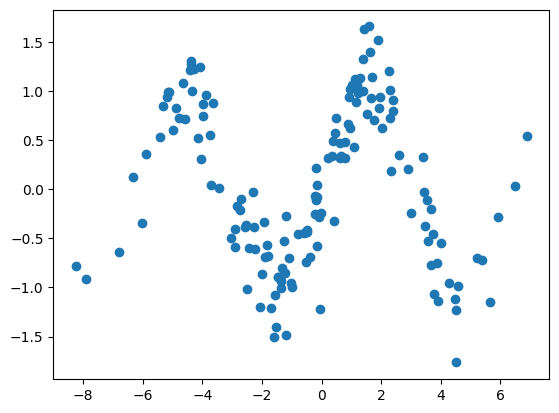

In [15]:
Random.seed!(1)
N = 150
X = randn(N, 1) * 3
y = sin.(vec(X)) + randn(N) * 0.3
plt.scatter(vec(X), y);

In [16]:
# bijector(GP(y, X))
Stacked{Tuple{Identity{0},Bijectors.Log{0},Bijectors.Log{0},Bijectors.Identity{1}},4}

Stacked{Tuple{Identity{0},Bijectors.Log{0},Bijectors.Log{0},Identity{1}},4}

In [17]:
Random.seed!(1)
m = GP(y, X, 0, 1, sqexp_cov_fn)  # data, num_components, nn_num_units
q0 = Variational.meanfield(m)  # initialize variational distribution (optional)
advi = ADVI(1, 2000)  # num_elbo_samples, max_iters
@time q = vi(m, advi, q0, optimizer=Flux.ADAM(1e-1));

[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:21


 27.847456 seconds (17.67 M allocations: 19.078 GiB, 5.29% gc time)


In [18]:
extract_gp = make_extractor(m, q)
mu = vec(extract_gp(:mu))
sig2 = vec(extract_gp(:sig2))
phi = vec(extract_gp(:phi));

In [19]:
function make_gp_predict(Xnew, y, X, cov_fn)
    N = size(X, 1)
    M = size(Xnew, 1)
    Q = N + M
    Z = [Xnew; X]
    D = pairwise(Euclidean(), Z, dims=1)
    
    return (mu, sig2, phi) -> let
        K = cov_fn(D, phi)
        Koo_inv = inv(K[(M+1):end, (M+1):end])
        Knn = K[1:M, 1:M]
        Kno = K[1:M, (M+1):end]
        C = Kno * Koo_inv
        m = C * (y .- mu) .+ mu
        S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
        # Base.show(stdout, "text/plain", S[1:3, 1:3])
        mvn = MvNormal(m, S + sig2 * LinearAlgebra.I)
        rand(mvn)
    end
end

make_gp_predict (generic function with 1 method)

In [20]:
Xnew = sort(rand(Uniform(minimum(X) - 2, maximum(X) + 2), 100, 1), dims=1)
gp_predict = make_gp_predict(Xnew, y, X, sqexp_cov_fn)
ynew = [gp_predict(mu[m], sig2[m], phi[m]) for m in 1:length(mu)]
ynew = hcat(ynew...);

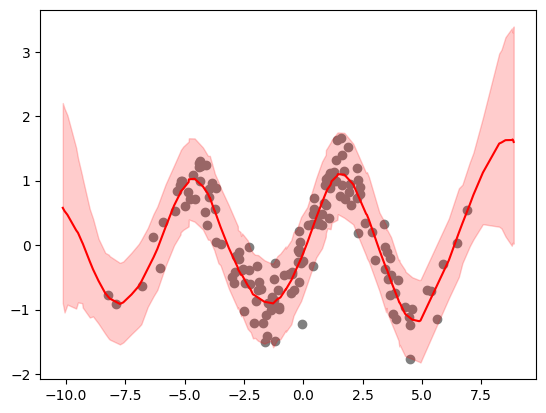

In [21]:
pred_mean = mean(ynew, dims=2)
pred_lower = quantiles(ynew, 0.025, dims=2)
pred_upper = quantiles(ynew, 0.975, dims=2)
plt.plot(vec(Xnew), vec(pred_mean), color="red")
plt.scatter(vec(X), vec(y), color="grey")
plt.fill_between(vec(Xnew), vec(pred_upper), vec(pred_lower), color="red", alpha=0.2);

***
# Warped Mixture with GP

In [22]:
function mvnorm_mix_logpdf(x, mu, Sigma, w)
    D, K = size(mu)  # dimension x num_components
    ll = [logpdf(MvNormal(mu[:, k], Sigma[k]), x) for k in 1:K]
    return logsumexp(ll .+ log.(w))
end

mvnorm_mix_logpdf (generic function with 1 method)

In [23]:
mm = MixtureModel([MvNormal(zeros(2), 1) for _ in 1:3])
# Bijectors.bijector(d::MixtureModel{MvNormal{T}}) where T = identity{1}()
Bijectors.bijector(d::MixtureModel{MvNormal{T}}) where T = Bijectors.TruncatedBijector{1, Float64, Float64}(-Inf, Inf)

In [24]:
# bijector(mm)
# bijector(MixtureModel([Normal(0, 1) for _ in 1:2]))

In [25]:
@model function warped_gp_mixture(Y, nmix=5, cov_fn=exp_cov_fn)
    nobs, nfeatures = size(Y)
    
    # Mixture weights
    w ~ Dirichlet(nmix, 1.0/nmix)
    
    # Mixture components:
    mu ~ filldist(MvNormal(zeros(2), 1.0), nmix)  # D x nmix
    # Sigma = Vector{Matrix{Float64}}(undef, nmix)
    # for k in 1:nmix
    #     Sigma[k] ~ InverseWishart(nfeatures + 2.0, eye(nfeatures))
    # end
    S1 ~ InverseWishart(nfeatures + 2.0, eye(nfeatures))
    S2 ~ InverseWishart(nfeatures + 2.0, eye(nfeatures))
    S3 ~ InverseWishart(nfeatures + 2.0, eye(nfeatures))
    S4 ~ InverseWishart(nfeatures + 2.0, eye(nfeatures))
    S5 ~ InverseWishart(nfeatures + 2.0, eye(nfeatures))
    
    # Latent variables.
    X ~ filldist(MixtureModel([MvNormal(mu[:, k], Sigma[k]) for k in 1:nmix]), nobs)
    # X ~ filldist(MvGMM(mu, [S1, S2, S3, S4, S5], w), nobs)
    # X ~ filldist(MvGMM(mu, Sigma, w), nobs)
    # Base.show(stdout, "text/plain", X[1:10, :]); println()
    
    # Co/Vairance parameters
    v ~ LogNormal(0, 1)
    phi ~ LogNormal(0, 10)
    
    # Sampling distribution.
    for d in 1:nfeatures
        Dd = pairwise(Euclidean(), reshape(X[d, :], nobs, 1), dims=1)
        Cd = cov_fn(Dd, phi)   
        Y[:, d] ~ MvNormal(zeros(nobs), Cd + LinearAlgebra.I * v)
    end
end

DynamicPPL.ModelGen{var"###generator#471",(:Y, :nmix, :cov_fn),(:nmix, :cov_fn),Tuple{Int64,typeof(exp_cov_fn)}}(##generator#471, (nmix = 5, cov_fn = exp_cov_fn))

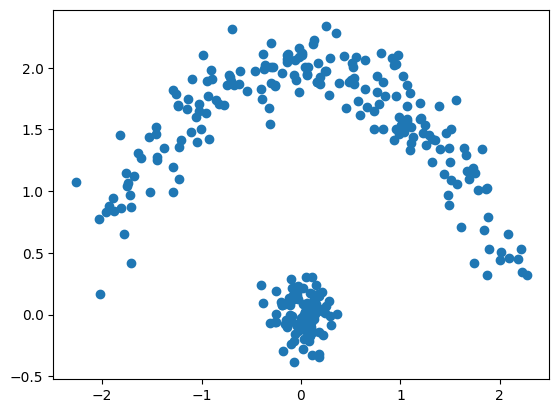

In [26]:
# Warped Data
function make_warped_data(n1=100, n2=200, r=2, s=0.15)
    Y1 = zeros(n1, 2)
    x2 = rand(n2) * r * 2 .- r
    y2 = sqrt.(r .^ 2 .- x2 .^ 2)
    Y2 = [x2 y2]
    return [Y1; Y2] + randn(n1 + n2, 2) * s
end
Y_warped = make_warped_data()
plt.scatter(Y_warped[:, 1], Y_warped[:, 2]);

In [27]:
Random.seed!(0)
m = warped_gp_mixture(Y_warped, 1, sqexp_cov_fn)
q0 = Variational.meanfield(m)  # initialize variational distribution (optional)
# advi = ADVI(1, 2000)  # num_elbo_samples, max_iters
# @time q = vi(m, advi, q0, optimizer=Flux.ADAM(1e-1));

UndefVarError: UndefVarError: Sigma not defined

In [28]:
chain = sample(m, SMC(), 1000)

UndefVarError: UndefVarError: Sigma not defined

In [29]:
length(mvgmm)

UndefVarError: UndefVarError: mvgmm not defined